In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
flux_path = "/Volumes/T9/vit/flux"
aia_path = "/Volumes/T9/PAPER_DATA_WITH_335/AIA"


In [3]:
def load_flux_contributions(timestamp: str):
    """Load flux contributions for a specific timestamp."""
    if flux_path is None:
        return None
    flux_file = flux_path + f"/{timestamp}"
    return np.loadtxt(flux_file, delimiter=',')


def load_aia_image(timestamp: str):
    """Load AIA image as RGB composite from 94, 131, 171 Angstrom channels."""
    if aia_path is None:
        return None
    
    # Search in subdirectories
    possible_dirs = [aia_path]
    for subdir in ['test', 'train', 'val']:
        subdir_path = aia_path + "/" + subdir
        possible_dirs.append(subdir_path)
    
    for aia_dir in possible_dirs:
        aia_file = aia_dir + f"/{timestamp}.npy"

        try:
            aia_data = np.load(aia_file)
            # Get 94, 131, 171 Angstrom channels
            aia_94 = aia_data[1]
            aia_131 = aia_data[2]
            aia_171 = aia_data[5]
            
            # Normalize and stack
            def normalize(arr):
                return (arr - np.min(arr)) / (np.max(arr) - np.min(arr) + 1e-10)
            
            return np.stack([normalize(aia_94), normalize(aia_131), normalize(aia_171)], axis=-1)
        except Exception as e:
            continue
    return None

In [44]:
# If the file is a numpy array saved with np.save, use np.load:
flux = load_flux_contributions("2023-07-01T07:25:00")
aia_image = load_aia_image("2023-07-01T07:25:00")

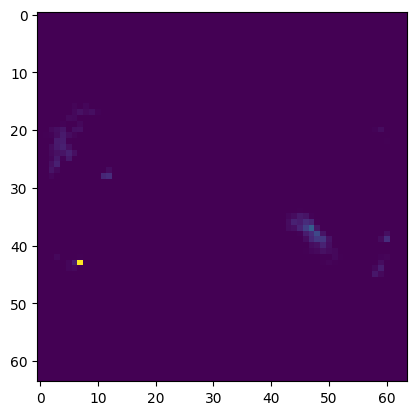

In [45]:
plt.imshow(flux)

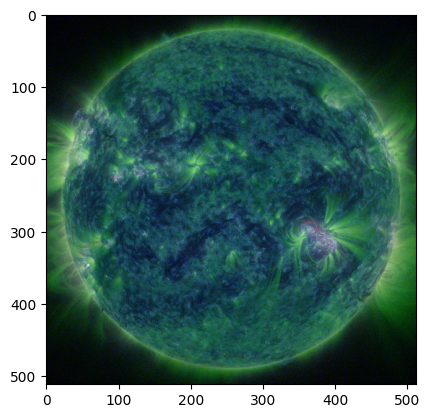

In [46]:
plt.imshow(aia_image)

In [47]:
from scipy.ndimage import maximum_filter, label, binary_dilation, binary_opening, binary_closing, binary_fill_holes,gaussian_filter
from scipy import ndimage as nd
from typing import Tuple, List, Dict
from collections import deque


def _find_flux_peaks(flux_contrib: np.ndarray,
                         neighborhood_size: int = 20) -> Tuple[List, List]:
        """Identify local maxima in the flux contribution map."""
        # Exclude 0s and nans from being counted as maxima
        flux_is_valid = (np.isfinite(flux_contrib)) & (flux_contrib > 0)
        # Use -inf for invalid pixels so maximum_filter never selects them
        valid_flux = np.where(flux_is_valid, flux_contrib, -np.inf)
        local_max = (maximum_filter(valid_flux, size=neighborhood_size) == valid_flux) & flux_is_valid
        peaks_mask = local_max
        peak_coords = np.where(peaks_mask)
        plt.figure()
        plt.imshow(peaks_mask)
        plt.title("Peaks Mask")
        peak_coords = list(zip(peak_coords[0], peak_coords[1]))
        peak_fluxes = [flux_contrib[y, x] for y, x in peak_coords]
        return peak_coords, peak_fluxes

In [55]:
from scipy.ndimage import maximum_filter, label, binary_dilation, binary_opening, binary_closing, binary_fill_holes,gaussian_filter
from scipy import ndimage as nd
from typing import Tuple, List, Dict
from collections import deque


def _find_flux_peaks(flux_contrib: np.ndarray,
                         neighborhood_size: int = 20) -> Tuple[List, List]:
        """Identify local maxima in the flux contribution map."""
        # Exclude 0s and nans from being counted as maxima
        flux_is_valid = (np.isfinite(flux_contrib)) & (flux_contrib > 0)
        # Use -inf for invalid pixels so maximum_filter never selects them
        valid_flux = np.where(flux_is_valid, flux_contrib, -np.inf)
        local_max = (maximum_filter(valid_flux, size=neighborhood_size) == valid_flux) & flux_is_valid
        peaks_mask = local_max
        peak_coords = np.where(peaks_mask)
        plt.figure()
        plt.imshow(peaks_mask)
        plt.title("Peaks Mask")
        peak_coords = list(zip(peak_coords[0], peak_coords[1]))
        peak_fluxes = [flux_contrib[y, x] for y, x in peak_coords]
        return peak_coords, peak_fluxes


def _detect_regions_with_peak_clustering(
    flux_contrib: np.ndarray,
) -> List[Dict]:
    """Detect regions using watershed segmentation for guaranteed non-overlapping regions.
    
    Watershed "floods" from peak markers and creates boundaries where regions meet,
    ensuring each pixel belongs to exactly one region.
    """
    import matplotlib.colors as colors
    from heapq import heappush, heappop

    threshold_std = 2
    min_flux = 1e-10
    peak_neighborhood = 10

    log_flux = np.log(flux_contrib)
    high_threshold = np.exp(np.median(log_flux) + threshold_std * np.std(log_flux))

    flux_mask = flux_contrib > high_threshold
    plt.figure()
    plt.imshow(flux_mask, cmap='gray')
    plt.title("Flux Mask (high threshold)")

    flux_contrib = np.where(flux_mask, flux_contrib, 0)
    # 1. SPATIAL SMOOTHING: Apply Gaussian filter to reduce noise
    sigma = 1
    if sigma > 0:
        flux_contrib = gaussian_filter(flux_contrib, sigma=sigma)

    plt.figure()
    vmin = max(np.min(flux_contrib[flux_contrib > 0]), 0)
    vmax = np.max(flux_contrib)
    plt.imshow(flux_contrib, norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    plt.colorbar()
    plt.title("Flux Contribution After Masking and Smoothing (LogNorm)")

    # Find peaks in the smoothed flux contribution
    peak_coords, peak_fluxes = _find_flux_peaks(
        flux_contrib, neighborhood_size=peak_neighborhood
    )
    
    if len(peak_coords) == 0:
        print("No peaks found!")
        return []
    
    # Initialize labels array
    labels = np.zeros_like(flux_contrib)
    
    # Initialize priority queue with all peaks (simultaneous start)
    # Priority queue format: (distance_from_peak, counter, y, x, label_id, peak_y, peak_x)
    # counter ensures stable sorting when distances are equal
    pq = []
    counter = 0
    # Define threshold as the value at the 10th percentile (bottom 10% quartile)
    # Ignore 0s and nans in threshold calculation
    valid_vals = flux_contrib[(flux_contrib > 0) & (~np.isnan(flux_contrib))]
    threshold = np.percentile(valid_vals, 10) if valid_vals.size > 0 else 0
    for peak_idx, ((peak_y, peak_x), peak_flux_value) in enumerate(zip(peak_coords, peak_fluxes)):
        label_id = peak_idx + 1
        labels[peak_y, peak_x] = label_id
        heappush(pq, (0.0, counter, peak_y, peak_x, label_id, peak_y, peak_x))
        counter += 1
    
    # Define neighbor offsets (8-connected for smoother radial growth)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),  # 4-connected
                 (-1, -1), (-1, 1), (1, -1), (1, 1)]  # diagonals
    
    # Radial growth from all peaks
    while pq:
        dist, _, y, x, label_id, peak_y, peak_x = heappop(pq)
        
        # Check neighbors
        for dy, dx in neighbors:
            ny, nx = y + dy, x + dx
            
            # Check bounds
            if (ny < 0 or ny >= flux_contrib.shape[0] or 
                nx < 0 or nx >= flux_contrib.shape[1]):
                continue
            
            # Check if already assigned to a region
            if labels[ny, nx] > 0:
                continue
            
            # Check if flux is above threshold
            if flux_contrib[ny, nx] > threshold:
                # Calculate distance from peak to this neighbor
                new_dist = np.sqrt((ny - peak_y)**2 + (nx - peak_x)**2)
                
                # Assign to this peak's region and continue growing
                labels[ny, nx] = label_id
                heappush(pq, (new_dist, counter, ny, nx, label_id, peak_y, peak_x))
                counter += 1
    
    plt.figure()
    plt.imshow(labels)
    plt.title("Regions from Radial Growth")

    return None

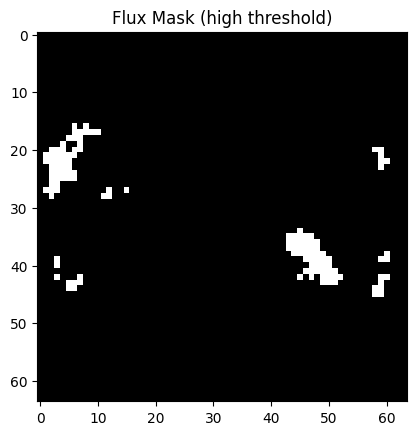

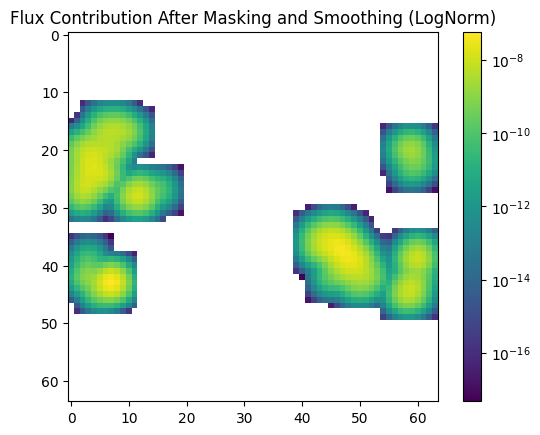

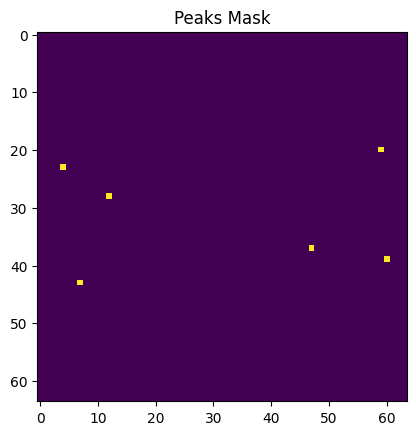

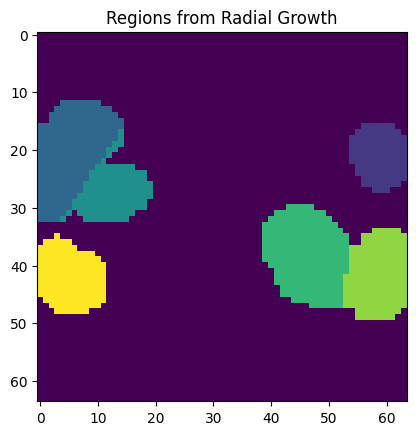

In [56]:
_detect_regions_with_peak_clustering(flux)